In [1]:
LEARNING_TYPE = "pointwise"
MODEL_CLASS = "BACF"
SAMPLER_TYPE = "lognormal"
SCORE_FN_TYPE = "prod"
DATA_NAME = "movielens"
MODEL_NAME = f"{MODEL_CLASS}_{SAMPLER_TYPE}_{SCORE_FN_TYPE}_{DATA_NAME}"

In [2]:
WORK_DIR_PATH = "../.."

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# WORK_DIR_PATH = "/content/drive/MyDrive/BACF/"

# Constants

In [4]:
# split
TRN_NEG_PER_POS = 4
TST_NEG_PER_POS = 99
LOO_NEG_PER_POS = TST_NEG_PER_POS
TRN_BATCH_SIZE = 256
TST_BATCH_SIZE = TRN_BATCH_SIZE
LOO_BATCH_SIZE = 1000
TRN_VAL_TST_RATIO = dict(trn=0.8, val=0.1, tst=0.1)
NEG_PER_POS_RATIO = dict(trn=TRN_NEG_PER_POS, val=TRN_NEG_PER_POS, tst=TST_NEG_PER_POS, loo=LOO_NEG_PER_POS)
BATCH_SIZE = dict(trn=TRN_BATCH_SIZE, val=TRN_BATCH_SIZE, tst=TST_BATCH_SIZE, loo=LOO_BATCH_SIZE)
HIST_SELECTOR_TYPE = "tfidf"
MAX_HIST = 400 if HIST_SELECTOR_TYPE=="tfidf" else None
SHUFFLE = True

In [5]:
# Model
N_FACTORS = 32
HIDDEN = [N_FACTORS*2, N_FACTORS*2, N_FACTORS, N_FACTORS//2]
HYPER_APPROX = 0.1
HYPER_PRIOR = 1.0
TAU = 1.0
BETA = 0.5
DROPOUT = 0.2

In [6]:
# how to learn
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
KL_LAMBDA = 1.0

In [7]:
# how to monitor
METRIC_FN_TYPE = "ndcg"
PATIENCE = 5
DELTA = 1e-3

In [8]:
# how to loop
N_EPOCHS = 1000
ANNEALING = 100
WARM_UP = 10
INTERVAL = 1

# Config

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\REPO\RESEARCH\2025-2 MDPI\BACF


In [ ]:
import pandas as pd
import torch
from BACF import bacf
from EXPERIMENT import UTILS
from EXPERIMENT.PIPELINE.builder import Builder
from EXPERIMENT.TRAINER.runner import Runner
from EXPERIMENT.TRAINER.monitor.monitor import EarlyStoppingMonitor
from EXPERIMENT.TRAINER.evaluator.evaluator import PerformanceEvaluator

In [ ]:
if LEARNING_TYPE=="listwise":
    from EXPERIMENT.TRAINER.trainer.listwise import CustomizedTrainer
    LOSS_FN_TYPE = "climf"

elif LEARNING_TYPE=="pairwise":
    from EXPERIMENT.TRAINER.trainer.pairwise import CustomizedTrainer
    LOSS_FN_TYPE = "bpr"

elif LEARNING_TYPE=="pointwise":
    from EXPERIMENT.TRAINER.trainer.pointwise import CustomizedTrainer
    LOSS_FN_TYPE = "bce"

else:
    raise ValueError()

In [ ]:
from EXPERIMENT.UTILS.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    COL_DICT,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
    SEED,
)

In [14]:
# seed
UTILS.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [15]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [16]:
data = pd.read_csv(f"./_data/{DATA_NAME}.csv")

In [17]:
# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [18]:
# data Description
UTILS.datahandler.description(data)

number of user: 610
number of item: 9724
total interaction: 100836
interaction density: 1.7000 %
max interaction of user: 2698
max interaction of item: 329
top 10.0 % interaction of user: 400.3
top 10.0 % interaction of item: 27.0
mean interaction of user: 165
mean interaction of item: 10


In [19]:
kwargs = dict(
    origin=data,
    learning_type=LEARNING_TYPE,
)

builder = Builder(**kwargs)

In [20]:
kwargs = dict(
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos_ratio=NEG_PER_POS_RATIO,
    batch_size=BATCH_SIZE,
    hist_selector_type=HIST_SELECTOR_TYPE,
    max_hist=MAX_HIST,
    shuffle=SHUFFLE,
)

loaders, interactions, histories = builder(**kwargs)

# Modeling

In [21]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
    hidden=HIDDEN,
    user_hist=histories["user"],
    hyper_approx=HYPER_APPROX,
    hyper_prior=HYPER_PRIOR,
    tau=TAU,
    beta=BETA,
    dropout=DROPOUT,
    sampler_type=SAMPLER_TYPE,
    score_fn_type=SCORE_FN_TYPE,
)

model = bacf.model.Module(**kwargs)

In [22]:
kwargs = dict(
    model=model,
    loss_fn_type=LOSS_FN_TYPE,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    kl_lambda=KL_LAMBDA,
)

trainer = CustomizedTrainer(**kwargs)

In [23]:
kwargs = dict(
    model=model,
    patience=PATIENCE,
    delta=DELTA,
    metric_fn_type=METRIC_FN_TYPE,
)

monitor = EarlyStoppingMonitor(**kwargs)

In [24]:
kwargs = dict(
    model=model,
    trainer=trainer,
    monitor=monitor,
)

runner = Runner(**kwargs)

# Train

In [25]:
kwargs = dict(
    trn_loader=loaders["trn"],
    val_loader=loaders["val"],
    loo_loader=loaders["loo"],
    n_epochs=N_EPOCHS,
    annealing=ANNEALING,
    warm_up=WARM_UP,
    interval=INTERVAL,
)

history = runner.fit(**kwargs)

LEAVE ONE OUT
	BEST SCORE: 0.6103
	BEST EPOCH: 10
COMPUTING COST FOR LEARNING
	(s/epoch): 0.9339
	(epoch/s): 1.0708
	(s/batch): 0.0372
	(batch/s): 26.8463


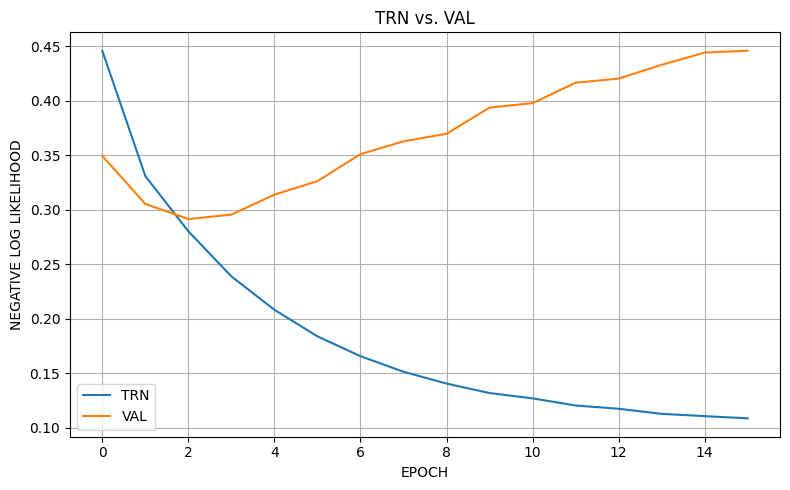

In [26]:
UTILS.visualizer.loss_plot(history["nll"], 'NEGATIVE LOG LIKELIHOOD')

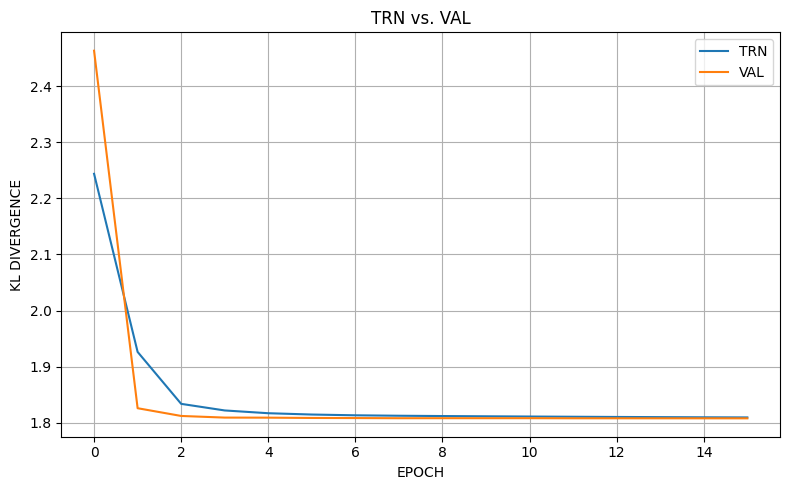

In [27]:
UTILS.visualizer.loss_plot(history["kl"], 'KL DIVERGENCE')

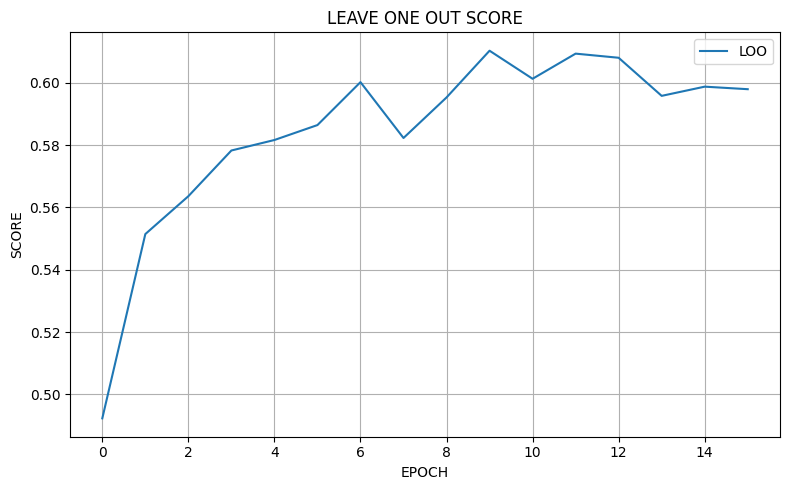

In [28]:
UTILS.visualizer.score_plot(history, 'SCORE')

# Test

In [29]:
evaluator = PerformanceEvaluator(model)

In [30]:
metrics_sheet = evaluator.evaluate(loaders["tst"])

COMPUTING COST FOR INFERENCE
	(s/epoch): 54.7638
	(epoch/s): 0.0183
	(s/batch): 0.0140
	(batch/s): 71.5071


In [31]:
metrics_sheet

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.903279,0.416721,0.322441,0.254032,0.508768
1,10,0.945902,0.312131,0.443832,0.304745,0.509273
2,15,0.973770,0.262295,0.514230,0.327581,0.522101
3,20,0.985246,0.227377,0.561364,0.340223,0.532369
4,25,0.988525,0.201311,0.595871,0.348404,0.540059
5,50,0.995082,0.133016,0.699157,0.368273,0.567881
6,100,1.000000,0.086361,0.799705,0.381654,0.602180


# Save

In [32]:
PATH = f'./_checkpoints/{LEARNING_TYPE}/{MODEL_NAME}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save(**kwargs)